In [1]:
import shdom
import numpy as np
import xarray as xr
import os
import sys
os.chdir('/Users/jesserl2/Documents/Code/aviad_pyshdom_dev/pyshdom_dev/')

file_name = 'test_forward3.nc'

In [3]:
#load the cloud.
cloud_scatterer = shdom.grid.load_from_csv('./synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))
#load atmosphere
atmosphere = xr.open_dataset('./ancillary_data/AFGL_summer_mid_lat.nc')
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 3.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = shdom.grid.combine_z_coordinates([cloud_scatterer, reduced_atmosphere])

#make a merged grid for the rte.
rte_grid = shdom.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           merged_z_coordinate)

#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = shdom.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
size_distribution_function = shdom.size_distribution.gamma
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))

In [8]:
cloud_scatterer

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 26)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    density  (x, y, z) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    reff     (x, y, z) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    density_name:  lwc
    file_name:     ./synthetic_cloud_fields/jpl_les/rico32x37x26.txt

In [5]:
size_distribution_function

<function shdom.size_distribution.gamma(radii, reff=None, veff=None, alpha=None, particle_density=1.0)>

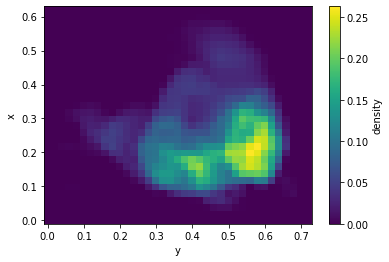

In [9]:
cloud_scatterer_on_rte_grid.density.mean('z').plot()

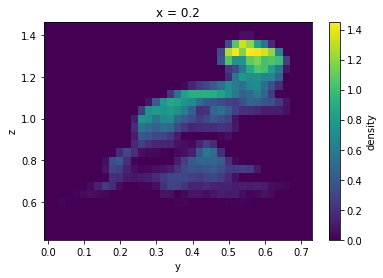

In [10]:
cloud_scatterer_on_rte_grid.density[10,:,1:27].T.plot()

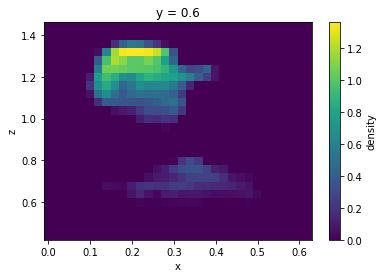

In [11]:
cloud_scatterer_on_rte_grid.density[:,30,1:27].T.plot()

In [20]:
#define sensors.
sensors_dict = shdom.util.SensorsDict()

sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90.0]*4 + [-90.0]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    shdom.sensor.orthographic_projection(0.86, cloud_scatterer,0.02,0.02,
                                                         azimuth, zenith,
                                                         altitude='TOA', stokes=['I'],
                                                         sub_pixel_ray_args={'method':shdom.sensor.gaussian,
                                                         'degree':2})
    )
for wavelength in (1.65, 2.2, 3.7):
    sensors_dict.add_sensor('MODIS',
                    shdom.sensor.orthographic_projection(wavelength,
                                                         cloud_scatterer,
                                                         0.02,0.02, 0.0,0.0,altitude='TOA',
                                                         stokes=['I'],
                                                         sub_pixel_ray_args={'method':shdom.sensor.gaussian,
                                                         'degree':2})
    )



In [13]:
sensors_dict['MISR']['sensor_list'][-1]

<xarray.Dataset>
Dimensions:            (bbox: 6, image_dims: 2, npixels: 1184, nrays: 4736, stokes_index: 4)
Coordinates:
  * stokes_index       (stokes_index) <U1 'I' 'Q' 'U' 'V'
  * bbox               (bbox) <U4 'xmin' 'ymin' 'zmin' 'xmax' 'ymax' 'zmax'
  * image_dims         (image_dims) <U2 'nx' 'ny'
Dimensions without coordinates: npixels, nrays
Data variables:
    wavelength         float64 0.86
    stokes             (stokes_index) bool True False False False
    cam_x              (npixels) float64 0.0 0.02 0.04 0.06 ... 0.58 0.6 0.62
    cam_y              (npixels) float64 0.0 0.0 0.0 0.0 ... 0.72 0.72 0.72 0.72
    cam_z              (npixels) float64 1.44 1.44 1.44 1.44 ... 1.44 1.44 1.44
    cam_mu             (npixels) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    cam_phi            (npixels) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bounding_box       (bbox) float64 0.0 0.0 0.44 0.62 0.72 1.44
    image_shape        (image_dims) int64 32 37
    ray_mu             (nrays) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ray_phi            (nrays) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ray_x              (nrays) float64 -0.005774 -0.005774 ... 0.6258 0.6258
    ray_y              (nrays) float64 -0.005774 0.005774 ... 0.7142 0.7258
    ray_z              (nrays) float64 1.44 1.44 1.44 1.44 ... 1.44 1.44 1.44
    pixel_index        (nrays) int64 0 0 0 0 1 1 ... 1182 1183 1183 1183 1183
    ray_weight         (nrays) float64 0.25 0.25 0.25 0.25 ... 0.25 0.25 0.25
    use_subpixel_rays  bool True
Attributes:
    projection:                 Orthographic
    altitude:                   1.44
    x_resolution:               0.02
    y_resolution:               0.02
    projection_azimuth:         0.0
    projection_zenith:          0.0
    sub_pixel_ray_args_method:  gaussian
    sub_pixel_ray_args_degree:  2

In [21]:
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()
solvers = shdom.util.SolversDict()

#rayleigh optical properties if desired.
rayleigh_scatterer_list = shdom.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

for wavelength in wavelengths:
    #optical properties from mie calculations.
    mie_mono_table = shdom.mie.get_mono_table('Water',(wavelength,wavelength), relative_path='./mie_tables')
    cloud_size_distribution = shdom.size_distribution.get_size_distribution_grid(
                                                            mie_mono_table.radius.data,
                        size_distribution_function=size_distribution_function,particle_density=1.0,
                        reff=[4.0,25.0,25,'logarithmic','micron'],
                        veff=[0.09,0.11,2,'linear','unitless'],
                        )
    poly_table = shdom.mie.get_poly_table(cloud_size_distribution,mie_mono_table)
    cloud_optical_scatterer = shdom.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    config = shdom.configuration.get_config('./default_config.json')
    # config['num_mu_bins'] = 16
    # config['num_phi_bins'] = 32
    # config['split_accuracy'] = 0.03
    # config['spherical_harmonics_accuracy'] = 0.0
    # config['solution_accuracy'] = 1e-5
    solvers.add_solver(wavelength, shdom.solver.RTE(numerical_params=config,
                                    medium={'cloud': cloud_optical_scatterer, 'rayleigh': rayleigh_scatterer_list[wavelength]},
                                   source=shdom.source.solar(-1*np.cos(np.deg2rad(40.0)),0.0,solarflux=1.0),
                                   surface=shdom.surface.lambertian(albedo=0.0),
                                    num_stokes=min_stokes[wavelength],
                                    name=None
                                   ))

making mie_table. . . may take a while.
making mie_table. . . may take a while.
making mie_table. . . may take a while.


In [22]:
solvers

SolversDict([(0.86, <shdom.solver.RTE at 0x151cbf4240>),
             (1.65, <shdom.solver.RTE at 0x151cceffd0>),
             (2.2, <shdom.solver.RTE at 0x151dcb8898>),
             (3.7, <shdom.solver.RTE at 0x151dcb8ef0>)])

In [23]:
#import mpi4py.MPI as MPI
#mpi_comm = MPI.COMM_WORLD
#print('I am {} of {}'.format(mpi_comm.Get_rank(), mpi_comm.Get_size()))

shdom.util.get_measurements(solvers, sensors_dict, n_jobs=4)

#if mpi_comm.Get_rank() == 0:
shdom.util.save_forward_model(file_name, sensors_dict, solvers)



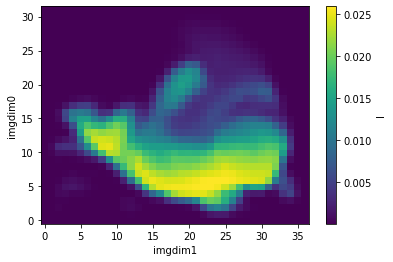

In [25]:
sensors_dict.get_image('MODIS',2).I.plot()

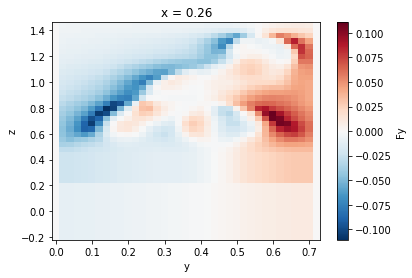

In [26]:
solvers[3.7].sh_out.Fy[13,:,0:27].T.plot()

In [6]:
solvers[0.86].sh_out.mean_intensity[10,:,0:27].T.plot()

NameError: name 'solvers' is not defined

In [ ]:
solvers[0.86].sh_out.mean_intensity[12,:,0:27].T.plot()

In [ ]:
solvers[2.2].medium['cloud'].extinction[12,:,0:27].T.plot()

In [ ]:
solvers[0.86].fluxes.flux_direct[:,20,0:27].T.plot()

In [ ]:
solvers[2.2].fluxes.flux_direct[:,20,0:27].T.plot()

In [ ]:
sensors_dict.get_image('MISR',-1).I.plot()